# Project name: [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

# Objective

Try new features or Get better than 0.923 score on [Public Leaderboard](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/leaderboard)

# Version

In [1]:
__ver__ = "0.6"

# Setup

In [2]:
import itertools
import warnings
import sys

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import lightgbm
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Data load

In [3]:
test_path = "./raw_data/test.csv.gz"
test = pd.read_csv(test_path).set_index('ID')

In [4]:
catboost_test = pd.read_pickle("./processed_data/catboost_test.pickle")
catboost_valid = pd.read_pickle("./processed_data/catboost_valid.pickle")

lightgbm_rf_test = pd.read_pickle("./processed_data/lightgbm_rf_test.pickle")
lightgbm_rf_valid = pd.read_pickle("./processed_data/lightgbm_rf_valid.pickle")

lightgbm_test = pd.read_pickle("./processed_data/lightgbm_test.pickle")
lightgbm_valid = pd.read_pickle("./processed_data/lightgbm_valid.pickle")

nn_test = pd.read_pickle("./processed_data/nn_test.pickle")
nn_valid = pd.read_pickle("./processed_data/nn_valid.pickle")

rf_test = pd.read_pickle("./processed_data/rf_test.pickle")
rf_valid = pd.read_pickle("./processed_data/rf_valid.pickle")

xgboost_test = pd.read_pickle("./processed_data/xgboost_test.pickle")
xgboost_valid = pd.read_pickle("./processed_data/xgboost_valid.pickle")

In [5]:
valid_y = pd.read_pickle("./processed_data/valid_target.pickle")

# Ensembling

## Stack data and show correlation

In [6]:
stack_valid = pd.concat([catboost_valid, lightgbm_valid, xgboost_valid, lightgbm_rf_valid, rf_valid, nn_valid], axis=1)
stack_test = pd.concat([catboost_test, lightgbm_test, xgboost_test, lightgbm_rf_test, rf_test, nn_test], axis=1)

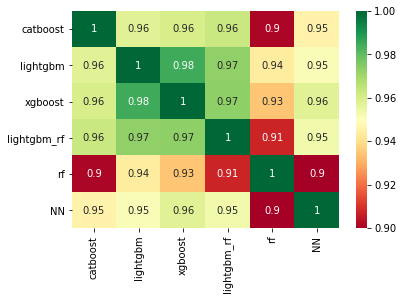

In [7]:
sns.heatmap(stack_valid.corr(), cmap="RdYlGn", annot=True)

**Public Leaderboard:**

In [8]:
# Catboost     - 0.93440
# LightGBM     - 0.93864
# XGBoost      - 0.94213
# LightGBM RF  - 0.94227
# RandomForest - 0.95773
# Simple NN    - 0.95999

RandomForest and Simple NN have low leaderboard results but also low correlations - so they can "diversify" errors of other models.

## Simple ensembling

I use lightgbm random forest "as is" for ensembling.

In [9]:
clf_params = dict(
    boosting_type="rf", 
    bagging_freq=1, 
    bagging_fraction=0.632, 
    feature_fraction=0.632,
    random_state=284704,
    n_estimators=100,
)
clf = lightgbm.LGBMRegressor(**clf_params)

clf.fit(
    stack_valid, 
    valid_y, 
)

LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
       class_weight=None, colsample_bytree=1.0, feature_fraction=0.632,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=284704, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

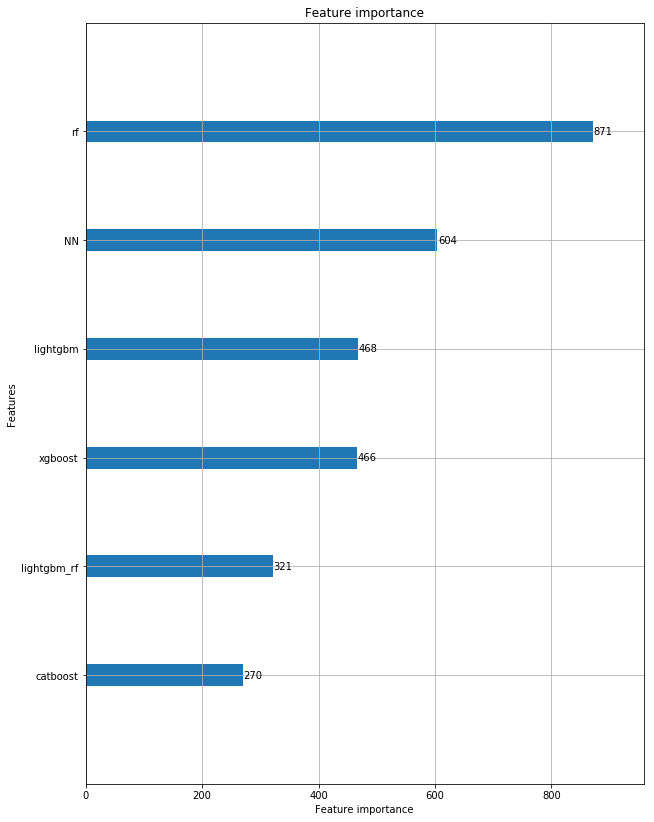

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
lightgbm.plot_importance(clf, ax=ax)

In [11]:
for col in stack_valid:
    print(col.ljust(15), f"{sklearn.metrics.mean_squared_error(stack_valid[col], valid_y):.5f}")
print()
print("Ensembling".ljust(15), f"{sklearn.metrics.mean_squared_error(clf.predict(stack_valid), valid_y):.5f}")

catboost        0.66845
lightgbm        0.67868
xgboost         0.67086
lightgbm_rf     0.68827
rf              0.78205
NN              0.68310

Ensembling      0.61431


## Ensembling with shop and item ids

I use lightgbm random forest "as is" for ensembling.

In [12]:
stack_valid = pd.concat([test, catboost_valid, lightgbm_valid, xgboost_valid, lightgbm_rf_valid, rf_valid, nn_valid], axis=1)
stack_test = pd.concat([test, catboost_test, lightgbm_test, xgboost_test, lightgbm_rf_test, rf_test, nn_test], axis=1)

In [13]:
clf_params = dict(
    boosting_type="rf", 
    bagging_freq=1, 
    bagging_fraction=0.632, 
    feature_fraction=0.632,
    random_state=284704,
    n_estimators=100,
)
clf = lightgbm.LGBMRegressor(**clf_params)

clf.fit(
    stack_valid, 
    valid_y, 
)

LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
       class_weight=None, colsample_bytree=1.0, feature_fraction=0.632,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=284704, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

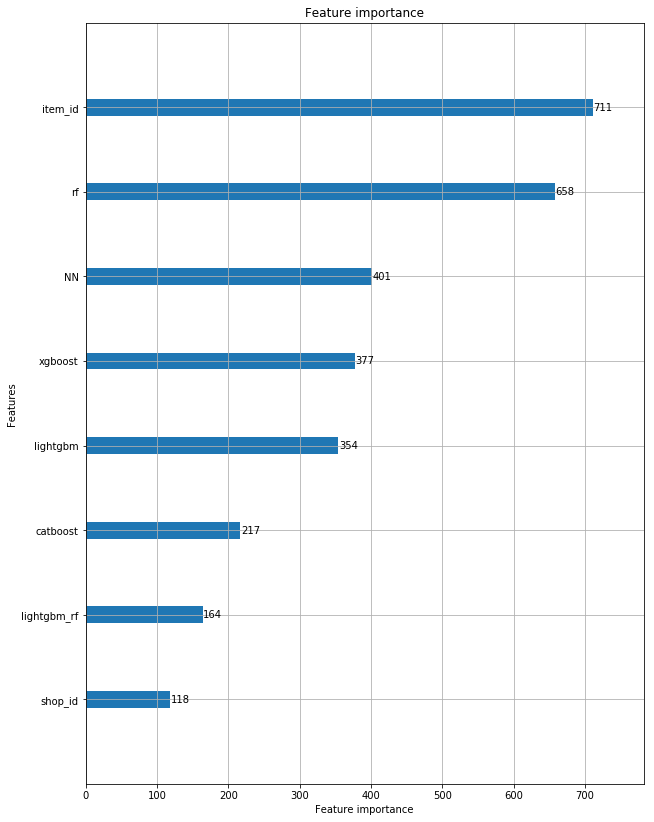

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
lightgbm.plot_importance(clf, ax=ax)

In [15]:
for col in stack_valid.iloc[:, 2:]:
    print(col.ljust(15), f"{sklearn.metrics.mean_squared_error(stack_valid[col], valid_y):.5f}")
print()
print("Ensembling".ljust(15), f"{sklearn.metrics.mean_squared_error(clf.predict(stack_valid), valid_y):.5f}")

catboost        0.66845
lightgbm        0.67868
xgboost         0.67086
lightgbm_rf     0.68827
rf              0.78205
NN              0.68310

Ensembling      0.55147


# Submission

In [16]:
sub_df = pd.DataFrame(
    clf.predict(stack_test), 
    index=test.index, 
    columns=["item_cnt_month"]
).clip(0, 20)
sub_df.index.name = "ID"

In [17]:
sub_path = f"./submissions/submission_{__ver__}.csv"
sub_df.to_csv(sub_path)